This notebook is to attempt to answer the question "Does frequency of attendance at small tournaments correlate with world or continental federation success?"

The main aim look at number of entries in smaller tournaments and to see how those numbers corelate or do not with success at the larger world and continental federation championships.

Imports

In [1]:
import pandas as pd
import chardet
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

Data ingestion

In [2]:
rankings = 'data/wkf_rankings.csv'
rankings_df = pd.read_csv(rankings)

Dropping 'id' and fixing time column data type

In [3]:
rankings_df.drop('_id', axis=1, inplace=True)
rankings_df['date']= pd.to_datetime(rankings_df['date'])

## Dropping the data after world pandemic travel restrictions

On March 11th 2020 a global pandemic was declared by the World Health Organisation (WHO) in light of the spread of the COVID-19 coronavirus. This subsequently caused many countries to impose travel restrictions and cancel events to prevent the spread.

As a result of this, data from events AFTER March 11 2020 will be removed as it cannot be gaurenteed that it is consistent with the rest of the data from periods with no travel restrictions and athletes not having the same preperation and training facilities.

In [4]:
rankings_df = rankings_df[rankings_df['date'] <= '2020-03-11']

Get rid of whitespace values

In [5]:
rankings_df.replace(u'\xa0',u'', regex=True, inplace=True)

## Beginning of investigation

In [6]:
rankings_df

,ranking_country,ranking_competitor,date,event,type,category,event_factor,rank,matches_won,points
0,AFG,AFG2082,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite -55 Kg,6.0,Participation,0.0,30.0
1,AFG,AFG02157,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite 84+ kg,6.0,Participation,2.0,150.0
2,AFG,AFG2002,2015-09-05,Karate1 Premier League - Istanbul 2015(TUR),Karate1 Premier League,Male Kumite -60 Kg,4.0,Participation,1.0,48.0
3,AFG,AFG02158,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite -84 kg,6.0,Participation,0.0,30.0
4,AFG,AFG114,2012-11-21,21st World Seniors Karate Championships(FRA),World Championship,Male Kumite -67 kg,12.0,Participation,1.0,144.0
...,...,...,...,...,...,...,...,...,...,...
119803,ZIM,ZIM02080,2019-07-12,UFAK Junior & Senior Championships - Gaborone ...,Continental Championship,Male Kumite -75 Kg,6.0,Participation,0.0,30.0
119804,ZIM,ZIM02080,2018-08-31,UFAK Junior & Senior Championships 2018(RWA),Continental Championship,Male Kumite -75 Kg,6.0,Participation,0.0,30.0
119805,ZIM,ZIM2009,2019-07-12,UFAK Junior & Senior Championships - Gaborone ...,Continental Championship,Junior Kumite Female -48 kg,6.0,Participation,0.0,30.0
119806,ZIM,ZIM2008,2018-05-29,TRANSITION POINTS_ZIM2008(ZIM),Others,Male Kumite -60 Kg,1.0,Participation,0.0,30.0


In [7]:
others_df = rankings_df[rankings_df['type'] == 'Others']

Firstly we'll create a dataframe based off the medalists of the worlds and regional continental championships

In [8]:
elite_medals_df = rankings_df[rankings_df['event_factor'] >= 6]
elite_medals_df = elite_medals_df.loc[(elite_medals_df['type'] == 'Continental Championship') | (elite_medals_df['type'] == 'World Championship')]
elite_medals_df = elite_medals_df[elite_medals_df['date'] >= '2012-01-01']

In [9]:
kata_data = elite_medals_df[elite_medals_df['category'].str.contains("Kata")].index
elite_medals_df.drop(kata_data, inplace = True)
elite_medals_df = elite_medals_df.reset_index(drop = True)

In [10]:
elite_medals_df

,ranking_country,ranking_competitor,date,event,type,category,event_factor,rank,matches_won,points
0,AFG,AFG2082,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite -55 Kg,6.0,Participation,0.0,30.0
1,AFG,AFG02157,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite 84+ kg,6.0,Participation,2.0,150.0
2,AFG,AFG02158,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite -84 kg,6.0,Participation,0.0,30.0
3,AFG,AFG114,2012-11-21,21st World Seniors Karate Championships(FRA),World Championship,Male Kumite -67 kg,12.0,Participation,1.0,144.0
4,AFG,AFG02159,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Female Kumite -61 kg,6.0,7th Place,0.0,150.0
...,...,...,...,...,...,...,...,...,...,...
24449,ZIM,ZIM005,2012-11-21,21st World Seniors Karate Championships(FRA),World Championship,Male Kumite -67 kg,12.0,Participation,1.0,144.0
24450,ZIM,ZIM02080,2019-07-12,UFAK Junior & Senior Championships - Gaborone ...,Continental Championship,Male Kumite -75 Kg,6.0,Participation,0.0,30.0
24451,ZIM,ZIM02080,2018-08-31,UFAK Junior & Senior Championships 2018(RWA),Continental Championship,Male Kumite -75 Kg,6.0,Participation,0.0,30.0
24452,ZIM,ZIM2009,2019-07-12,UFAK Junior & Senior Championships - Gaborone ...,Continental Championship,Junior Kumite Female -48 kg,6.0,Participation,0.0,30.0


In [11]:
elite_medals_df['rank'].unique()

array(['Participation', '7th Place', '3rd Place', '9th Place',
       '5th Place', '2nd Place', '1st Place', '11th Place', '13th Place'],
      dtype=object)

In [12]:
len(elite_medals_df['ranking_competitor'].unique())

9730

In [13]:
len(elite_medals_df['ranking_country'].unique())

172

In [14]:
elite_last_8_df = elite_medals_df.loc[(elite_medals_df['rank'] == '1st Place') |
                                      (elite_medals_df['rank'] == '2nd Place') |
                                     (elite_medals_df['rank'] == '3rd Place') | 
                                      (elite_medals_df['rank'] == '5th Place') | 
                                      (elite_medals_df['rank'] == '7th Place')]

elite_medals_df = elite_medals_df.loc[(elite_medals_df['rank'] == '1st Place') |
                                      (elite_medals_df['rank'] == '2nd Place') |
                                     (elite_medals_df['rank'] == '3rd Place')]

In [15]:
elite_medals_df

,ranking_country,ranking_competitor,date,event,type,category,event_factor,rank,matches_won,points
15,ALB,ALB2002,2016-02-05,"43rd EKF Junior, Cadet and U21 Championships(CYP)",Continental Championship,U21 Kumite Male -60 kg,6.0,3rd Place,4.0,510.0
47,ALB,ALB2001,2014-02-07,"41st European Karate Championship for Cadets, ...",Continental Championship,Under 21 Kumite Male -78 kg,6.0,2nd Place,4.0,516.0
78,ALG,ALG02639,2020-02-07,UFAK Junior & Senior Championships - Tangier 2...,Continental Championship,Junior Kumite Female 59+ kg,6.0,2nd Place,1.0,510.0
80,ALG,ALG02679,2020-02-07,UFAK Junior & Senior Championships - Tangier 2...,Continental Championship,Junior Kumite Female -53 kg,6.0,1st Place,2.0,750.0
84,ALG,ALG208,2018-08-31,UFAK Junior & Senior Championships 2018(RWA),Continental Championship,Male Kumite -75 Kg,6.0,3rd Place,4.0,510.0
...,...,...,...,...,...,...,...,...,...,...
24321,VIE,VIE2003,2016-11-21,"15th AKF Cadet, Junior & U-21 Championships(INA)",Continental Championship,U21 Kumite Female -50 kg,6.0,3rd Place,2.0,390.0
24324,VIE,VIE2003,2015-09-04,13th AKF Senior Championships(JPN),Continental Championship,Female Kumite -50 Kg,6.0,3rd Place,3.0,450.0
24330,VIE,VIE2030,2015-11-12,"World Junior, Cadet and U21 Championships 2015...",World Championship,U21 Kumite Female -55 kg,12.0,2nd Place,4.0,1032.0
24332,VIE,VIE2198,2019-04-26,"18th AKF CADET, JUNIOR and U21 CHAMPIONSHIP, K...",Continental Championship,Cadet Kumite Male -70 kg,6.0,3rd Place,3.0,450.0


In [16]:
len(elite_last_8_df)

7687

In [17]:
len(elite_medals_df)

4167

#### With the two dataframes with last 8 and last medalists from the elite events we can start getting counts based on competitor and then country

In [18]:
elite_last_8_ind_df = elite_last_8_df.drop(['ranking_country','date','event','type','category','event_factor', 'rank',
                     'matches_won','points'], axis=1)

elite_last_8_countries_df = elite_last_8_df.drop(['ranking_competitor','date','event','type','category','event_factor', 'rank',
                     'matches_won','points'], axis=1)

elite_medals_ind_df = elite_medals_df.drop(['ranking_country','date','event','type','category','event_factor', 'rank',
                     'matches_won','points'], axis=1)

elite_medals_countries_df = elite_medals_df.drop(['ranking_competitor','date','event','type','category','event_factor', 'rank',
                     'matches_won','points'], axis=1)

In [19]:
elite_last_8_ind_df = elite_last_8_ind_df.groupby(['ranking_competitor']).size().reset_index().rename(columns={0:'Last 8'})

elite_last_8_countries_df = elite_last_8_countries_df.groupby(['ranking_country']).size().reset_index().rename(columns={0:'Last 8'})

elite_medals_ind_df = elite_medals_ind_df.groupby(['ranking_competitor']).size().reset_index().rename(columns={0:'Medals'})

elite_medals_countries_df = elite_medals_countries_df.groupby(['ranking_country']).size().reset_index().rename(columns={0:'Medals'})

In [20]:
elite_last_8_ind_df

,ranking_competitor,Last 8
0,AFG02159,1
1,AHO112,1
2,ALB150,1
3,ALB155,1
4,ALB2001,3
...,...,...
4288,VIE2202,1
4289,VIE2204,1
4290,VIE2205,1
4291,WKF2019,1


In [21]:
elite_last_8_countries_df

,ranking_country,Last 8
0,AFG,1
1,ALB,6
2,ALG,52
3,AND,2
4,ANG,1
...,...,...
142,USA,242
143,UZB,62
144,VAN,2
145,VEN,209


In [22]:
elite_medals_ind_df

,ranking_competitor,Medals
0,ALB2001,1
1,ALB2002,1
2,ALG02552,2
3,ALG02556,1
4,ALG02637,1
...,...,...
2426,VIE2195,1
2427,VIE2198,1
2428,VIE2202,1
2429,WKF2019,1


In [23]:
elite_medals_countries_df

,ranking_country,Medals
0,ALB,2
1,ALG,41
2,ARG,36
3,ARM,4
4,AUS,146
...,...,...
116,URU,8
117,USA,115
118,UZB,35
119,VEN,137


#### Now to get an entry count for the same timeframe and making sure to remove "others" for the points insertions.

#### We will narrow the analysis to only include competitors that have ENTERED those competitions that would allow them to be counted in the medals or last-8. So we need to get a list of all the entrants and then add them to our existing dataframes.

In [24]:
elite_entrants_df = rankings_df[rankings_df['event_factor'] >= 6]
elite_entrants_df = elite_entrants_df.loc[(elite_entrants_df['type'] == 'Continental Championship') | (elite_entrants_df['type'] == 'World Championship')]
elite_entrants_df = elite_entrants_df[elite_entrants_df['date'] >= '2012-01-01']

In [25]:
kata_data = elite_entrants_df[elite_entrants_df['category'].str.contains("Kata")].index
elite_entrants_df.drop(kata_data, inplace = True)
elite_entrants_df = elite_entrants_df.reset_index(drop = True)

In [26]:
elite_entrants_df

,ranking_country,ranking_competitor,date,event,type,category,event_factor,rank,matches_won,points
0,AFG,AFG2082,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite -55 Kg,6.0,Participation,0.0,30.0
1,AFG,AFG02157,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite 84+ kg,6.0,Participation,2.0,150.0
2,AFG,AFG02158,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite -84 kg,6.0,Participation,0.0,30.0
3,AFG,AFG114,2012-11-21,21st World Seniors Karate Championships(FRA),World Championship,Male Kumite -67 kg,12.0,Participation,1.0,144.0
4,AFG,AFG02159,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Female Kumite -61 kg,6.0,7th Place,0.0,150.0
...,...,...,...,...,...,...,...,...,...,...
24449,ZIM,ZIM005,2012-11-21,21st World Seniors Karate Championships(FRA),World Championship,Male Kumite -67 kg,12.0,Participation,1.0,144.0
24450,ZIM,ZIM02080,2019-07-12,UFAK Junior & Senior Championships - Gaborone ...,Continental Championship,Male Kumite -75 Kg,6.0,Participation,0.0,30.0
24451,ZIM,ZIM02080,2018-08-31,UFAK Junior & Senior Championships 2018(RWA),Continental Championship,Male Kumite -75 Kg,6.0,Participation,0.0,30.0
24452,ZIM,ZIM2009,2019-07-12,UFAK Junior & Senior Championships - Gaborone ...,Continental Championship,Junior Kumite Female -48 kg,6.0,Participation,0.0,30.0


In [27]:
elite_countries_df = elite_entrants_df.drop(['ranking_competitor','date','event','type','category','event_factor', 'rank',
                     'matches_won','points'], axis=1)

elite_countries_df = elite_countries_df.drop_duplicates().reset_index(drop = True)

In [28]:
elite_competitors_df = elite_entrants_df.drop(['ranking_country','date','event','type','category','event_factor', 'rank',
                     'matches_won','points'], axis=1)

elite_competitors_df = elite_competitors_df.drop_duplicates().reset_index(drop = True)

In [29]:
elite_competitors_df

,ranking_competitor
0,AFG2082
1,AFG02157
2,AFG02158
3,AFG114
4,AFG02159
...,...
9725,ZIM2007
9726,ZIM005
9727,ZIM02080
9728,ZIM2009


In [30]:
elite_countries_df

,ranking_country
0,AFG
1,ALB
2,ALG
3,AND
4,ANG
...,...
167,WAL
168,WLF
169,YEM
170,ZAM


#### Time to merge up all the dataframes with the entrants.

In [31]:
# Merge for last 8 individuals
elite_last_8_ind_df = elite_last_8_ind_df.merge(elite_competitors_df, on='ranking_competitor', how='outer')
elite_last_8_ind_df = elite_last_8_ind_df.replace(np.nan, 0)

# Merge for last 8 countries
elite_last_8_countries_df = elite_last_8_countries_df.merge(elite_countries_df, on='ranking_country', how='outer')
elite_last_8_countries_df = elite_last_8_countries_df.replace(np.nan, 0)

# Merge for medals individuals
elite_medals_ind_df = elite_medals_ind_df.merge(elite_competitors_df, on='ranking_competitor', how='outer')
elite_medals_ind_df = elite_medals_ind_df.replace(np.nan, 0)

# Merge for medals countries
elite_medals_countries_df = elite_medals_countries_df.merge(elite_countries_df, on='ranking_country', how='outer')
elite_medals_countries_df = elite_medals_countries_df.replace(np.nan, 0)

And then combine them all into one table

In [32]:
competitors_df = elite_medals_ind_df.merge(elite_last_8_ind_df, on='ranking_competitor', how='outer')
competitors_df = competitors_df.replace(np.nan, 0)

countries_df = elite_medals_countries_df.merge(elite_last_8_countries_df, on='ranking_country', how='outer')
countries_df = countries_df.replace(np.nan, 0)

In [33]:
countries_df

,ranking_country,Medals,Last 8
0,ALB,2.0,6.0
1,ALG,41.0,52.0
2,ARG,36.0,83.0
3,ARM,4.0,11.0
4,AUS,146.0,159.0
...,...,...,...
167,WAL,0.0,0.0
168,WLF,0.0,0.0
169,YEM,0.0,0.0
170,ZAM,0.0,0.0


In [34]:
competitors_df

,ranking_competitor,Medals,Last 8
0,ALB2001,1.0,3.0
1,ALB2002,1.0,1.0
2,ALG02552,2.0,2.0
3,ALG02556,1.0,1.0
4,ALG02637,1.0,1.0
...,...,...,...
9725,ZIM2007,0.0,0.0
9726,ZIM005,0.0,0.0
9727,ZIM02080,0.0,0.0
9728,ZIM2009,0.0,0.0


#### We now have counts of all the entrants of the continental and world championships along with their medal and last 8 counts both by competitors and last 8.

# Creating a count for lower tournaments

To create the lower entries dataframe we could try taking a new copy of the rankings dataframe and using the elite entries as a remover for what has already been counted, so entries of the those tournaments themselves will not be counted.

We can also use the same method for removing the "others" entries.

In [35]:
lower_entries_df = rankings_df.copy()
lower_entries_df = lower_entries_df[lower_entries_df['date'] >= '2011-01-01']

# Deciding to include all entries as some competitors only attended these events and the
# still count as expierience
#lower_entries_df = lower_entries_df.loc[(lower_entries_df['type'] != 'Continental Championship') & (lower_entries_df['type'] != 'World Championship') &
#                                      (lower_entries_df['type'] != 'Invitational Championship')]

lower_entries_df

,ranking_country,ranking_competitor,date,event,type,category,event_factor,rank,matches_won,points
0,AFG,AFG2082,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite -55 Kg,6.0,Participation,0.0,30.0
1,AFG,AFG02157,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite 84+ kg,6.0,Participation,2.0,150.0
2,AFG,AFG2002,2015-09-05,Karate1 Premier League - Istanbul 2015(TUR),Karate1 Premier League,Male Kumite -60 Kg,4.0,Participation,1.0,48.0
3,AFG,AFG02158,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite -84 kg,6.0,Participation,0.0,30.0
4,AFG,AFG114,2012-11-21,21st World Seniors Karate Championships(FRA),World Championship,Male Kumite -67 kg,12.0,Participation,1.0,144.0
...,...,...,...,...,...,...,...,...,...,...
119803,ZIM,ZIM02080,2019-07-12,UFAK Junior & Senior Championships - Gaborone ...,Continental Championship,Male Kumite -75 Kg,6.0,Participation,0.0,30.0
119804,ZIM,ZIM02080,2018-08-31,UFAK Junior & Senior Championships 2018(RWA),Continental Championship,Male Kumite -75 Kg,6.0,Participation,0.0,30.0
119805,ZIM,ZIM2009,2019-07-12,UFAK Junior & Senior Championships - Gaborone ...,Continental Championship,Junior Kumite Female -48 kg,6.0,Participation,0.0,30.0
119806,ZIM,ZIM2008,2018-05-29,TRANSITION POINTS_ZIM2008(ZIM),Others,Male Kumite -60 Kg,1.0,Participation,0.0,30.0


In [36]:
kata_data = lower_entries_df[lower_entries_df['category'].str.contains("Kata")].index
lower_entries_df.drop(kata_data, inplace = True)
lower_entries_df = lower_entries_df.reset_index(drop = True)

In [37]:
lower_entries_df['type'].unique()

array(['Continental Championship', 'Karate1 Premier League',
       'World Championship', 'Karate1 Youth League', 'Others',
       'Karate1 Series A', 'Karate1 World Cup',
       'WKF Accredited Competition', 'Mediterranean Games',
       'Invitational Championship'], dtype=object)

In [38]:
others_data = lower_entries_df[lower_entries_df['type'].str.contains("Others")].index
lower_entries_df.drop(others_data, inplace = True)
lower_entries_df = lower_entries_df.reset_index(drop = True)

In [39]:
lower_entries_df

,ranking_country,ranking_competitor,date,event,type,category,event_factor,rank,matches_won,points
0,AFG,AFG2082,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite -55 Kg,6.0,Participation,0.0,30.0
1,AFG,AFG02157,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite 84+ kg,6.0,Participation,2.0,150.0
2,AFG,AFG2002,2015-09-05,Karate1 Premier League - Istanbul 2015(TUR),Karate1 Premier League,Male Kumite -60 Kg,4.0,Participation,1.0,48.0
3,AFG,AFG02158,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite -84 kg,6.0,Participation,0.0,30.0
4,AFG,AFG114,2012-11-21,21st World Seniors Karate Championships(FRA),World Championship,Male Kumite -67 kg,12.0,Participation,1.0,144.0
...,...,...,...,...,...,...,...,...,...,...
76320,ZIM,ZIM005,2012-11-21,21st World Seniors Karate Championships(FRA),World Championship,Male Kumite -67 kg,12.0,Participation,1.0,144.0
76321,ZIM,ZIM02080,2019-07-12,UFAK Junior & Senior Championships - Gaborone ...,Continental Championship,Male Kumite -75 Kg,6.0,Participation,0.0,30.0
76322,ZIM,ZIM02080,2018-08-31,UFAK Junior & Senior Championships 2018(RWA),Continental Championship,Male Kumite -75 Kg,6.0,Participation,0.0,30.0
76323,ZIM,ZIM2009,2019-07-12,UFAK Junior & Senior Championships - Gaborone ...,Continental Championship,Junior Kumite Female -48 kg,6.0,Participation,0.0,30.0


In [40]:
lower_entries_df['event_factor'].unique()

array([ 6.,  4., 12.,  3.,  5.,  2.,  1.,  7.])

In [41]:
lower_entries_df.loc[lower_entries_df['event_factor'] == 6]

,ranking_country,ranking_competitor,date,event,type,category,event_factor,rank,matches_won,points
0,AFG,AFG2082,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite -55 Kg,6.0,Participation,0.0,30.0
1,AFG,AFG02157,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite 84+ kg,6.0,Participation,2.0,150.0
3,AFG,AFG02158,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite -84 kg,6.0,Participation,0.0,30.0
7,AFG,AFG02159,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Female Kumite -61 kg,6.0,7th Place,0.0,150.0
8,AFG,AFG02160,2019-07-19,"16TH AKF SENIOR CHAMPIONSHIP 2019, TASHKENT, U...",Continental Championship,Male Kumite -60 Kg,6.0,Participation,0.0,30.0
...,...,...,...,...,...,...,...,...,...,...
76305,ZIM,ZIM02078,2019-07-12,UFAK Junior & Senior Championships - Gaborone ...,Continental Championship,Junior Kumite Female 59+ kg,6.0,Participation,0.0,30.0
76306,ZIM,ZIM2007,2019-07-12,UFAK Junior & Senior Championships - Gaborone ...,Continental Championship,Male Kumite -60 Kg,6.0,Participation,0.0,30.0
76321,ZIM,ZIM02080,2019-07-12,UFAK Junior & Senior Championships - Gaborone ...,Continental Championship,Male Kumite -75 Kg,6.0,Participation,0.0,30.0
76322,ZIM,ZIM02080,2018-08-31,UFAK Junior & Senior Championships 2018(RWA),Continental Championship,Male Kumite -75 Kg,6.0,Participation,0.0,30.0


In [42]:
lower_competitors_df = lower_entries_df.drop(['ranking_country','date','event','type','category','event_factor', 'rank',
                     'matches_won','points'], axis=1)
lower_countries_df = lower_entries_df.drop(['ranking_competitor','date','event','type','category','event_factor', 'rank',
                     'matches_won','points'], axis=1)

In [43]:
lower_competitors_df = lower_competitors_df.groupby(['ranking_competitor']).size().reset_index().rename(columns={0:'entries'})
lower_competitors_df.head()

,ranking_competitor,entries
0,AFG02157,1
1,AFG02158,1
2,AFG02159,1
3,AFG02160,1
4,AFG02161,1


In [44]:
lower_countries_df = lower_countries_df.groupby(['ranking_country']).size().reset_index().rename(columns={0:'entries'})
lower_countries_df.head()

,ranking_country,entries
0,AFG,13
1,ALB,191
2,ALG,445
3,AND,88
4,ANG,2


### Now to merge everything up

In [45]:
countries_df = countries_df.merge(lower_countries_df, on='ranking_country', how='left')
countries_df = countries_df.replace(np.nan, 0)

competitors_df = competitors_df.merge(lower_competitors_df, on='ranking_competitor', how='left')
competitors_df = competitors_df.replace(np.nan, 0)

In [46]:
countries_df

,ranking_country,Medals,Last 8,entries
0,ALB,2.0,6.0,191
1,ALG,41.0,52.0,445
2,ARG,36.0,83.0,466
3,ARM,4.0,11.0,219
4,AUS,146.0,159.0,735
...,...,...,...,...
167,WAL,0.0,0.0,153
168,WLF,0.0,0.0,4
169,YEM,0.0,0.0,12
170,ZAM,0.0,0.0,7


In [47]:
countries_df.describe()

,Medals,Last 8,entries
count,172.000000,172.000000,172.000000
mean,24.226744,44.691860,443.662791
std,40.256063,61.669591,648.032372
min,0.000000,0.000000,1.000000
25%,0.000000,2.000000,29.000000
50%,6.000000,16.500000,131.000000
75%,34.000000,62.500000,599.500000
max,195.000000,319.000000,4259.000000


In [48]:
competitors_df

,ranking_competitor,Medals,Last 8,entries
0,ALB2001,1.0,3.0,32
1,ALB2002,1.0,1.0,47
2,ALG02552,2.0,2.0,2
3,ALG02556,1.0,1.0,2
4,ALG02637,1.0,1.0,2
...,...,...,...,...
9725,ZIM2007,0.0,0.0,2
9726,ZIM005,0.0,0.0,13
9727,ZIM02080,0.0,0.0,2
9728,ZIM2009,0.0,0.0,1


In [49]:
competitors_df.describe()

,Medals,Last 8,entries
count,9730.000000,9730.000000,9730.000000
mean,0.428263,0.790031,6.070504
std,0.976675,1.278716,9.010151
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,1.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,1.000000,6.000000
max,11.000000,12.000000,78.000000


In [50]:
competitors_df[['ranking_competitor','Medals','entries']]

,ranking_competitor,Medals,entries
0,ALB2001,1.0,32
1,ALB2002,1.0,47
2,ALG02552,2.0,2
3,ALG02556,1.0,2
4,ALG02637,1.0,2
...,...,...,...
9725,ZIM2007,0.0,2
9726,ZIM005,0.0,13
9727,ZIM02080,0.0,2
9728,ZIM2009,0.0,1


In [51]:
countries_df[['ranking_country','Medals','entries']]

,ranking_country,Medals,entries
0,ALB,2.0,191
1,ALG,41.0,445
2,ARG,36.0,466
3,ARM,4.0,219
4,AUS,146.0,735
...,...,...,...
167,WAL,0.0,153
168,WLF,0.0,4
169,YEM,0.0,12
170,ZAM,0.0,7


With everything merged we can start comparing collerations

## Lets get some figures!

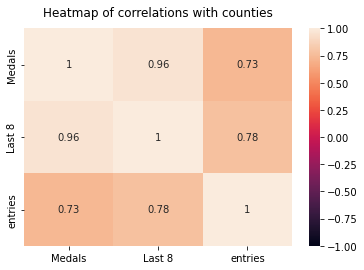

In [52]:
heatmap = sns.heatmap(countries_df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Heatmap of correlations with counties', fontdict={'fontsize':12}, pad=12)
pass

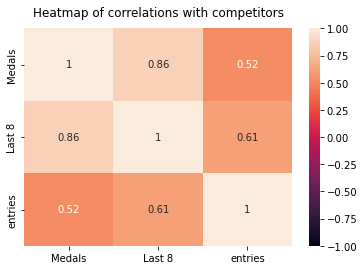

In [53]:
heatmap = sns.heatmap(competitors_df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Heatmap of correlations with competitors', fontdict={'fontsize':12}, pad=12)
pass

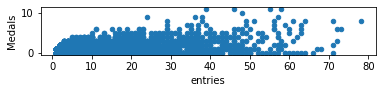

In [54]:
competitors_df.plot.scatter(x='entries',
                         y='Medals').set_aspect(1)

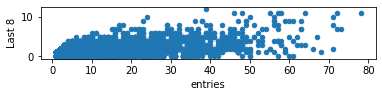

In [55]:
competitors_df.plot.scatter(x='entries',
                         y='Last 8').set_aspect(1)

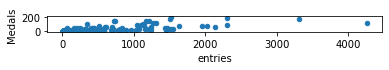

In [56]:
countries_df.plot.scatter(x='entries',
                         y='Medals').set_aspect(1)

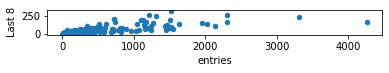

In [57]:
countries_df.plot.scatter(x='entries',
                         y='Last 8').set_aspect(1)

## Competitor entries to Medals

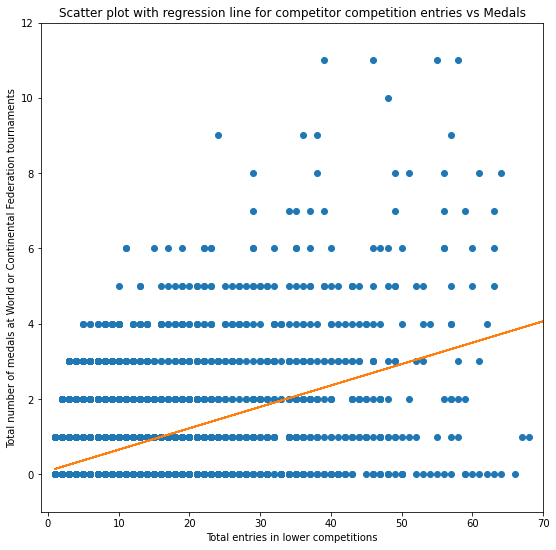

In [58]:
plt.figure(figsize=(9,9)) # Keep figure square
plt.xlim(-1, 70) # scale for the max rank value
plt.ylim(-1, 12) # scale for the max rank value

plt.title('Scatter plot with regression line for competitor competition entries vs Medals')

x = np.array(competitors_df['entries'])
plt.xlabel('Total entries in lower competitions')
y = np.array(competitors_df['Medals'])
plt.ylabel('Total number of medals at World or Continental Federation tournaments')

plt.plot(x,y,'o')

m, b = np.polyfit(x, y, 1)

plt.plot(x, m*x + b)

In [59]:
(r, p) = scipy.stats.pearsonr(competitors_df['entries'],
                              competitors_df['Medals'])

print('r: {r}, p: {p}'.format(r=r, p=p))

r: 0.5245246850120483, p: 0.0


## Country entries to Medals

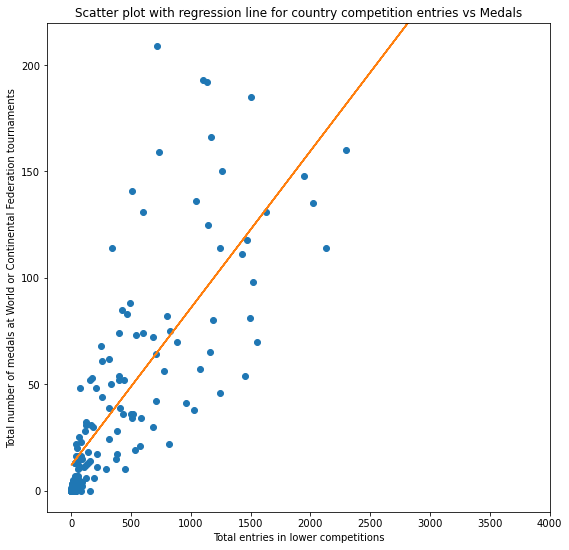

In [60]:
plt.figure(figsize=(9,9)) # Keep figure square
plt.xlim(-200, 4000) # scale for the max rank value
plt.ylim(-10, 220) # scale for the max rank value

plt.title('Scatter plot with regression line for country competition entries vs Medals')

x = np.array(countries_df['entries'])
plt.xlabel('Total entries in lower competitions')
y = np.array(countries_df['Last 8'])
plt.ylabel('Total number of medals at World or Continental Federation tournaments')

plt.plot(x,y,'o')

m, b = np.polyfit(x, y, 1)

plt.plot(x, m*x + b)

In [61]:
(r, p) = scipy.stats.pearsonr(countries_df['entries'],
                              countries_df['Medals'])

print('r: {r}, p: {p}'.format(r=r, p=p))

r: 0.7273476217427385, p: 1.3371594693780745e-29


In [62]:
countries_df.loc[(countries_df['Medals'] > 175)]

,ranking_country,Medals,Last 8,entries
13,BRA,195.0,319.0,1523
113,TUR,189.0,256.0,2303


In [63]:
countries_df.loc[(countries_df['ranking_country'] == 'SCO')]

,ranking_country,Medals,Last 8,entries
101,SCO,14.0,36.0,514


## Some other visualisations

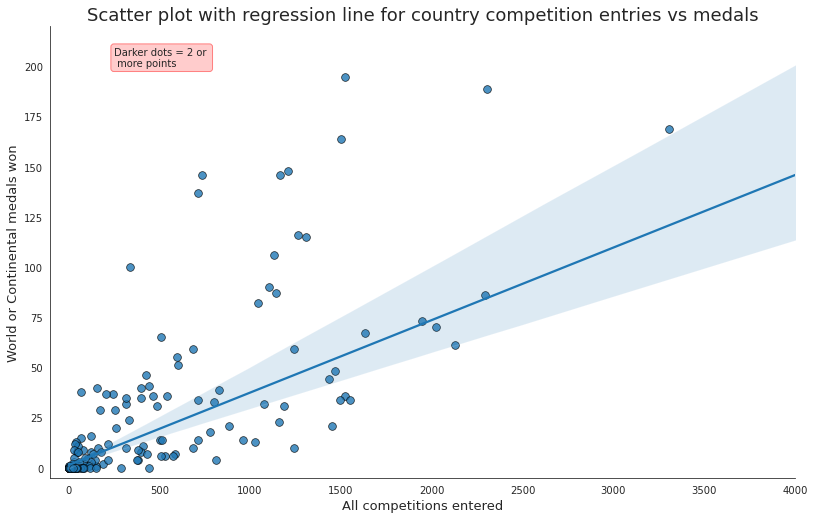

In [64]:
# Plot
sns.set_style("white")
gridobj = sns.lmplot(x="entries", y="Medals", data=countries_df, 
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

# Decorations
gridobj.set(xlim=(-100, 4000), ylim=(-5, 220))
plt.title("Scatter plot with regression line for country competition entries vs medals", fontsize=18)
plt.xlabel("All competitions entered", fontsize=13)
plt.ylabel("World or Continental medals won", fontsize=13)
plt.text(250,200,'Darker dots = 2 or \n more points',bbox=dict(boxstyle="round",
                                                            ec=(1., 0.5, 0.5),
                                                            fc=(1., 0.8, 0.8)))
plt.show()

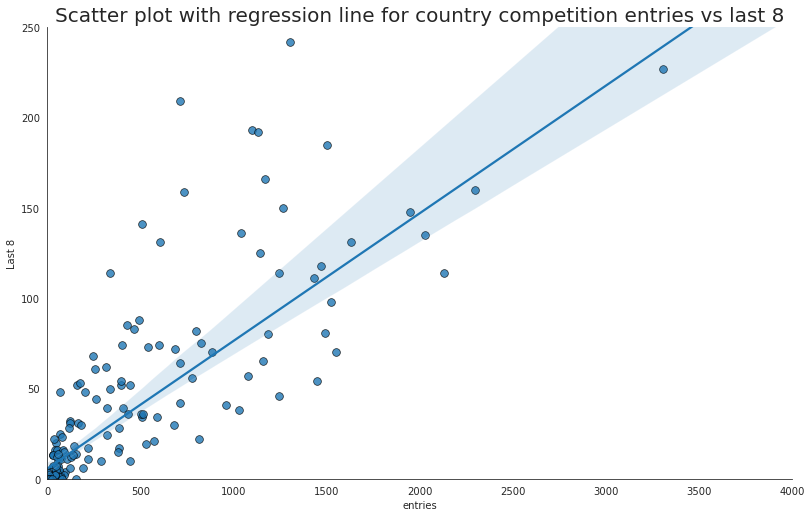

In [65]:
# Plot
sns.set_style("white")
gridobj = sns.lmplot(x="entries", y="Last 8", data=countries_df, 
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

# Decorations
gridobj.set(xlim=(0, 4000), ylim=(0, 250))
plt.title("Scatter plot with regression line for country competition entries vs last 8", fontsize=20)
plt.show()

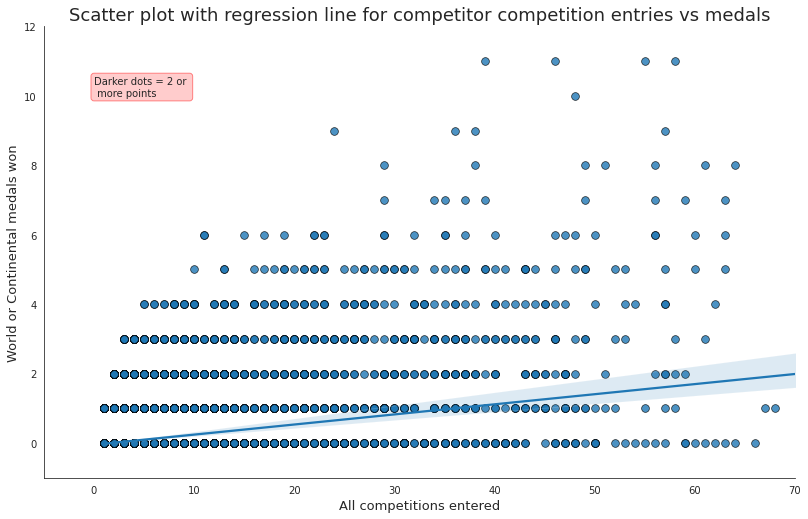

In [66]:
# Plot
sns.set_style("white")
gridobj = sns.lmplot(x="entries", y="Medals", data=competitors_df, 
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

# Decorations
gridobj.set(xlim=(-5, 70), ylim=(-1, 12))
plt.title("Scatter plot with regression line for competitor competition entries vs medals", fontsize=18)
plt.xlabel("All competitions entered", fontsize=13)
plt.ylabel("World or Continental medals won", fontsize=13)
plt.text(0,10,'Darker dots = 2 or \n more points',bbox=dict(boxstyle="round",
                                                            ec=(1., 0.5, 0.5),
                                                            fc=(1., 0.8, 0.8)))
plt.show()

In [ ]:
# Plot
sns.set_style("white")
gridobj = sns.lmplot(x="entries", y="Last 8", data=competitors_df, 
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

# Decorations
gridobj.set(xlim=(-5, 70), ylim=(-1, 15))
plt.title("Scatter plot with regression line for competitor competition entries vs last 8", fontsize=20)
plt.show()

## Some machine learning - Countries

In [ ]:
key1 = 'entries'
key2 = 'Medals'

In [ ]:
# Create an instance of the clusterer with k=2
kmeans2 = KMeans(n_clusters=2)
clusteringData_df = countries_df[[key1, key2]]
clusteringData_df.head()

In [ ]:
# Call the fit function on the clusterer to fit the data to the 2 means.
assignedClusters_clust = kmeans2.fit(clusteringData_df)
# Plot the data points which in the cluster labelled '0'
plt.scatter(countries_df[key1][assignedClusters_clust.labels_==0],
            countries_df[key2][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(countries_df[key1][assignedClusters_clust.labels_==1],
            countries_df[key2][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

plt.legend()

plt.xlabel(key1)
plt.ylabel(key2)

plt.title('2-means Clustering')

plt.plot()
pass

In [ ]:
# Create an instance of the clusterer with k=3
kmeans3 = KMeans(n_clusters=3)
# Call the fit function on the clusterer to fit the data to the 2 means.
assignedClusters_clust = kmeans3.fit(clusteringData_df)
# Plot the data points which in the cluster labelled '0'
plt.scatter(countries_df[key1][assignedClusters_clust.labels_==0],
            countries_df[key2][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(countries_df[key1][assignedClusters_clust.labels_==1],
            countries_df[key2][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# Plot the data points which in the cluster labelled '2'
plt.scatter(countries_df[key1][assignedClusters_clust.labels_==2],
            countries_df[key2][assignedClusters_clust.labels_==2],
            color='green', marker='o', label='cluster 2')

plt.legend()

plt.xlabel(key1)
plt.ylabel(key2)

plt.title('3-means Clustering')

plt.plot()
pass

In [ ]:
# Create an instance of the clusterer with k=4
kmeans3 = KMeans(n_clusters=4)
# Call the fit function on the clusterer to fit the data to the 2 means.
assignedClusters_clust = kmeans3.fit(clusteringData_df)
# Plot the data points which in the cluster labelled '0'
plt.scatter(countries_df[key1][assignedClusters_clust.labels_==0],
            countries_df[key2][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(countries_df[key1][assignedClusters_clust.labels_==1],
            countries_df[key2][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# Plot the data points which in the cluster labelled '2'
plt.scatter(countries_df[key1][assignedClusters_clust.labels_==2],
            countries_df[key2][assignedClusters_clust.labels_==2],
            color='green', marker='o', label='cluster 2')

# Plot the data points which in the cluster labelled '3'
plt.scatter(countries_df[key1][assignedClusters_clust.labels_==3],
            countries_df[key2][assignedClusters_clust.labels_==3],
            color='yellow', marker='o', label='cluster 3')

plt.legend()

plt.xlabel(key1)
plt.ylabel(key2)

plt.title('4-means Clustering')

plt.plot()
pass

In [ ]:
initialCentroids_df = pd.DataFrame({key1: [0, 200, 0, 200],
                                    key2: [0, 0, 4000, 4000]},
                                   columns=[key1, key2])
initialCentroids_df

## More machine learning - competitors

In [ ]:
key1 = 'entries'
key2 = 'Medals'

In [ ]:
# Create an instance of the clusterer with k=2
kmeans2 = KMeans(n_clusters=2)
clusteringData_df = competitors_df[[key1, key2]]
clusteringData_df.head()

In [ ]:
# Call the fit function on the clusterer to fit the data to the 2 means.
assignedClusters_clust = kmeans2.fit(clusteringData_df)
# Plot the data points which in the cluster labelled '0'
plt.scatter(competitors_df[key1][assignedClusters_clust.labels_==0],
            competitors_df[key2][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(competitors_df[key1][assignedClusters_clust.labels_==1],
            competitors_df[key2][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

plt.legend()

plt.xlabel(key1)
plt.ylabel(key2)

plt.title('2-means Clustering')

plt.plot()
pass

In [ ]:
# Create an instance of the clusterer with k=3
kmeans3 = KMeans(n_clusters=3)
# Call the fit function on the clusterer to fit the data to the 2 means.
assignedClusters_clust = kmeans3.fit(clusteringData_df)
# Plot the data points which in the cluster labelled '0'
plt.scatter(competitors_df[key1][assignedClusters_clust.labels_==0],
            competitors_df[key2][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(competitors_df[key1][assignedClusters_clust.labels_==1],
            competitors_df[key2][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# Plot the data points which in the cluster labelled '2'
plt.scatter(competitors_df[key1][assignedClusters_clust.labels_==2],
            competitors_df[key2][assignedClusters_clust.labels_==2],
            color='green', marker='o', label='cluster 2')

plt.legend()

plt.xlabel(key1)
plt.ylabel(key2)

plt.title('3-means Clustering')

plt.plot()
pass

In [ ]:
# Create an instance of the clusterer with k=4
kmeans4 = KMeans(n_clusters=4)
# Call the fit function on the clusterer to fit the data to the 2 means.
assignedClusters_clust = kmeans4.fit(clusteringData_df)
# Plot the data points which in the cluster labelled '0'
plt.scatter(competitors_df[key1][assignedClusters_clust.labels_==0],
            competitors_df[key2][assignedClusters_clust.labels_==0],
            color='red', marker='o', label='cluster 0')

# Plot the data points which in the cluster labelled '1'
plt.scatter(competitors_df[key1][assignedClusters_clust.labels_==1],
            competitors_df[key2][assignedClusters_clust.labels_==1],
            color='blue', marker='o', label='cluster 1')

# Plot the data points which in the cluster labelled '2'
plt.scatter(competitors_df[key1][assignedClusters_clust.labels_==2],
            competitors_df[key2][assignedClusters_clust.labels_==2],
            color='green', marker='o', label='cluster 2')

# Plot the data points which in the cluster labelled '3'
plt.scatter(competitors_df[key1][assignedClusters_clust.labels_==3],
            competitors_df[key2][assignedClusters_clust.labels_==3],
            color='orange', marker='o', label='cluster 3')

plt.legend()

plt.xlabel(key1)
plt.ylabel(key2)

plt.title('4-means Clustering')

plt.plot()
pass

None of these are really helping as K-NN cant distinguise between in medals (the "good" variable) and entries

## Cluster measuring - countries

In [ ]:
clusteringData_df = countries_df[['Medals', 'Last 8', 'entries']]
clusteringData_df.head()

In [ ]:
# Create an instance of the clusterer
kmeans3 = KMeans(n_clusters=3)
assignedClusters = kmeans3.fit(clusteringData_df)

In [ ]:
silhouetteData_df = pd.DataFrame(
    {'silhouette':silhouette_samples(clusteringData_df,assignedClusters.labels_),
     'cluster':assignedClusters.labels_})
silhouetteData_df.head()

In [ ]:
silhouetteData_df.sort_values(['cluster', 'silhouette'], inplace=True)
silhouetteData_df.index = range(len(silhouetteData_df))

colourMap = {0:'red',
             1:'blue',
             2:'lightGreen'}

fig, ax = plt.subplots()
fig.set_size_inches(11, 8)

for cluster in set(silhouetteData_df['cluster']):
    ax.bar(silhouetteData_df[silhouetteData_df['cluster']==cluster].index,
           silhouetteData_df[silhouetteData_df['cluster']==cluster]['silhouette'],
           color=colourMap[cluster],
           label='Cluster {}'.format(cluster), width=1)

ax.set_title('Silhouette plot of countries results data, clustered with $k$-means, $k$=3')

ax.set_xlabel('Number of data point')
ax.set_ylabel('Silhouette coefficient')
ax.legend()
pass

In [ ]:
def silhouettes(k, df):
    # Create an instance of the clusterer
    kmeans = KMeans(n_clusters=k)
    assignedClusters = kmeans.fit(df)
    silhouetteData_df = pd.DataFrame(
        {'silhouette':silhouette_samples(df, assignedClusters.labels_),
         'cluster':assignedClusters.labels_})

    silhouetteData_df.sort_values(['cluster', 'silhouette'], inplace=True)
    silhouetteData_df.index = range(len(silhouetteData_df))

    colourMap = {0: 'red',
                 1: 'blue',
                 2: 'green',
                 3: 'orange',
                 4: 'gray',
                5: 'teal',
                6: 'yellow',
                7: 'black',
                8: 'cyan',
                9: 'megenta',
                10: 'brown'}

    fig, ax = plt.subplots()
    fig.set_size_inches(11, 8)

    for cluster in set(silhouetteData_df['cluster']):
        ax.bar(silhouetteData_df[silhouetteData_df['cluster']==cluster].index,
               silhouetteData_df[silhouetteData_df['cluster']==cluster]['silhouette'],
               color=colourMap[cluster],
               label='Cluster {}'.format(cluster), width=1)

    ax.set_title('Silhouette plot of male penguin data, clustered with $k$-means, $k$='+str(k))

    ax.set_xlabel('Number of data point')
    ax.set_ylabel('Silhouette coefficient')
    fig.set_size_inches(11, 8)
    ax.legend()


In [ ]:
silhouettes(2, clusteringData_df)

In [ ]:
silhouettes(3, clusteringData_df)

In [ ]:
silhouettes(4, clusteringData_df)

In [ ]:
silhouettes(5, clusteringData_df)

In [ ]:
silhouettes(6, clusteringData_df)

In [ ]:
silhouettes(7, clusteringData_df)

In [ ]:
silhouettes(8, clusteringData_df)

In [ ]:
silhouettes(9, clusteringData_df)

Nothing in K-NN or the visualisation from it really helps to demonstrate anything so will be disregarded from the report.